In [116]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [118]:
ticker = 'MSFT'
df = yf.download(ticker, '2020-01-01')

C:\Users\luism\AppData\Local\Temp\ipykernel_860\3186683050.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, '2020-01-01')
[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

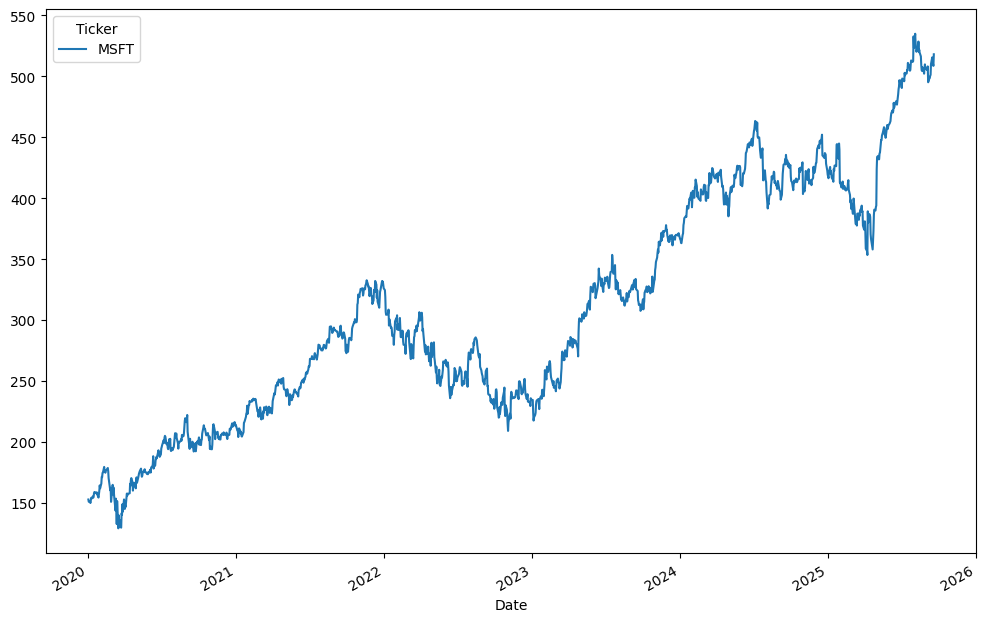

In [119]:

df.Close.plot(figsize=(12,8))

In [120]:
df

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
Date,,,,,
2020-01-02,152.791092,152.895731,150.612717,151.040780,22622100
2020-01-03,150.888596,152.153771,150.355893,150.603230,21116200
2020-01-06,151.278625,151.345221,148.881450,149.423674,20813700
2020-01-07,149.899292,151.887418,149.651970,151.554487,21634100
2020-01-08,152.286957,152.962357,150.251264,151.183494,27746500
...,...,...,...,...,...
2025-09-15,515.359985,515.469971,507.000000,508.790009,17143800
2025-09-16,509.040009,517.229980,508.600006,516.880005,19711900


In [121]:
scaler = StandardScaler()

df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,MSFT
Date,
2020-01-02,-1.633961
2020-01-03,-1.654047
2020-01-06,-1.649929
2020-01-07,-1.664492
2020-01-08,-1.639284
...,...
2025-09-15,2.193911
2025-09-16,2.127187
2025-09-17,2.137533


In [122]:
seq_length = 31
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)

X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)



In [123]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
    
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1,:])
        
        return out
        

In [124]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

In [125]:
criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [126]:
num_epochs = 200

for i in range(num_epochs):
    y_train_pred = model(X_train)

    loss = criterion(y_train_pred, y_train)

    if i % 25 == 0:
        print(i, loss.item())

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    

0 0.6084017753601074
25 0.016574185341596603
50 0.007846938446164131
75 0.006880263797938824
100 0.006401959806680679
125 0.006180508527904749
150 0.005876229610294104
175 0.005402370821684599


In [127]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test= scaler.inverse_transform(y_test.detach().cpu().numpy())



In [128]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:,0])

In [129]:
train_rmse

6.983150005340576

In [130]:
test_rmse

16.892093658447266

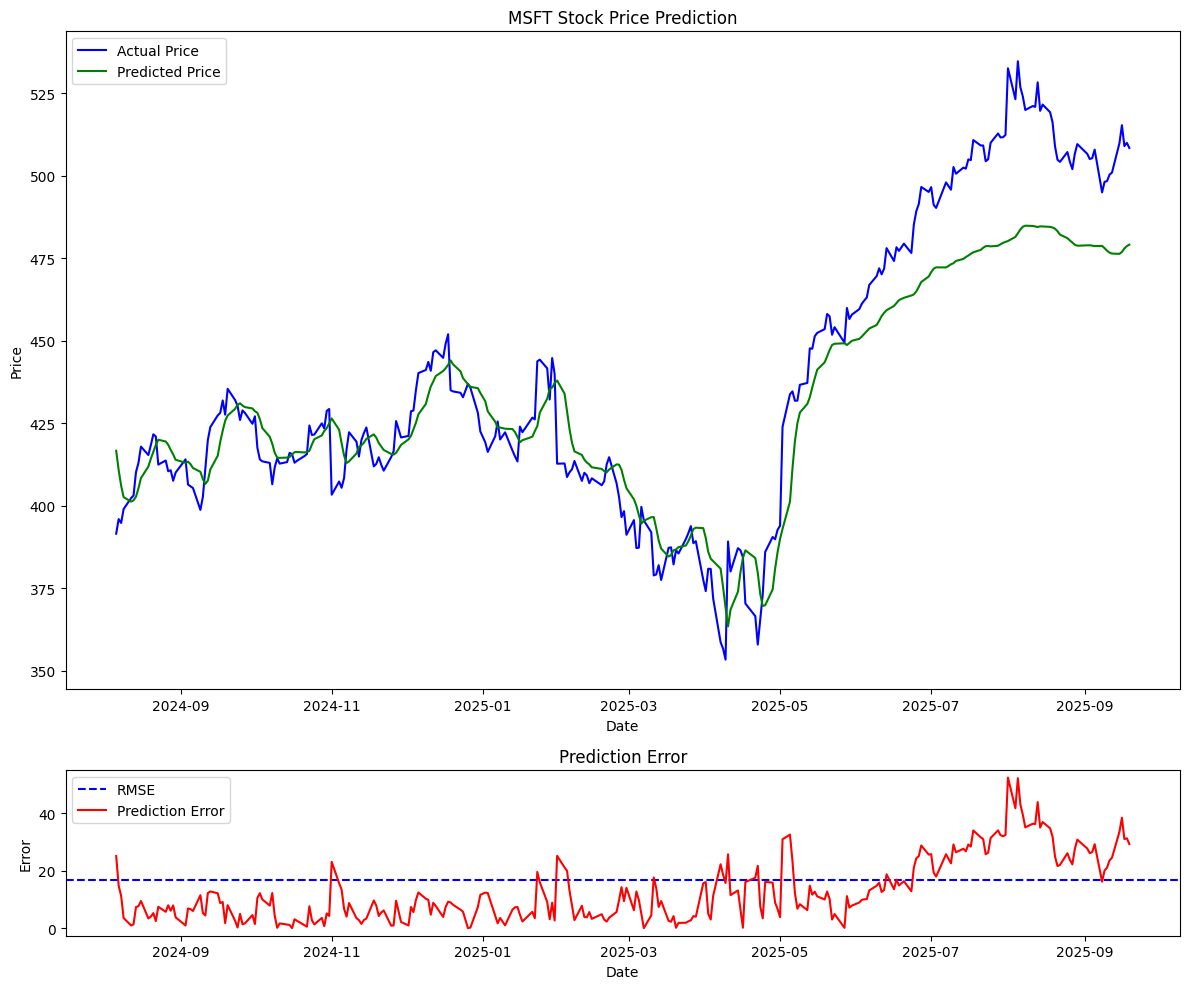

In [131]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0:3 ,0])
ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label = 'RMSE')
ax2.plot(df[-len(y_test):].index, abs(y_test - y_test_pred), 'r', label= 'Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')

plt.tight_layout()
plt.show()